In [10]:
import os #agora nao precisa
import urllib.request #agora nao precisa
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [11]:
%%bash 
head './data/daily-minimum-temperatures.csv'

"Date","Temp"
"1981-01-01",20.7
"1981-01-02",17.9
"1981-01-03",18.8
"1981-01-04",14.6
"1981-01-05",15.8
"1981-01-06",15.8
"1981-01-07",15.8
"1981-01-08",17.4
"1981-01-09",21.8


In [12]:
dados = np.genfromtxt('./data/daily-minimum-temperatures.csv', delimiter=',')

In [13]:
path = 'data/daily-minimum-temperatures.csv'
df = pd.read_csv(path)
# Set the country code as index of the DataFrame
#df = df.set_index('Date')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [14]:
# hyperparameter
# K = number of previous days used as input data
K = 10

# k-fold
# F = number of folds used for cross validation
F = 10

In [15]:
date = df['Date']
temp = df['Temp']
size = len(date)

In [16]:
df.mean()

Temp    11.177753
dtype: float64

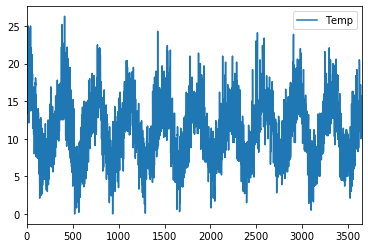

In [17]:
df.plot()
plt.show()

In [9]:
x = size*[0]  # list with arrays: x(K), x(K+1), ... , x(size)
y = size*[0]  # list with arrays: y(K), y(K+1), ... , y(size)
# note that for x(N), when N < K, data is missing
for N in range(K, size):
    y[N] = np.array([[temp[N]]])
    x[N] = np.array([])
    # we want x(N - 1), ... , x(N - K)
    for i in range(1, K+1):
        # append K previous samples of data in x[N] array
        x[N] = np.append(x[N], temp[N-i])
    # transform x[N] in a 2D array and transpose it
    x[N] = np.array([x[N]]).T

In [ ]:
#-----------------------------
# test set
#-----------------------------
#(df.Date.values == '1990-01-01').argmax()  #pandas
index = df.Date.eq('1990-01-01').idxmax()   #numpy
x_ts = x[index:size]
y_ts = y[index:size]

In [ ]:
#-----------------------------
# training set (divide in groups)
#-----------------------------
# unlike standard cross-validation methods, successive training sets are supersets of those that come before them
samples_size = size - len(x_ts)     # total samples to be divided in k folds
fold_size = int(samples_size / F)   # equal size of each fold
plus_one = samples_size % F         # number of folds that will receive +1 sample

# split training set in groups
gx = []  # list with x data arrays: group_1, ... , group_F
gy = []  # list with y data arrays: group_1, ... , group_F
for i in range(F):
    # add 1 sample to first groups if needed
    if(plus_one > i):
        gx.append(x[i*fold_size : (i*fold_size + fold_size+1)])
        gy.append(y[i*fold_size : (i*fold_size + fold_size+1)])
    else:
        gx.append(x[i*fold_size : (i*fold_size + fold_size)])
        gy.append(y[i*fold_size : (i*fold_size + fold_size)])

# remove first K data from first group
for i in range(K):
    gx[0].pop(0)
    gy[0].pop(0)

joing groups to form folds

fx[i] contains the data for the iteration i of the training (for F folds)

fx[0] = gx[0] ... fx[F-2] = gx[0] + ... + gx[F-2]

fy[i] contains the data for the iteration i of the training (for F folds)

fy[0] = gy[0] ... fy[F-2] = gy[0] + ... + gx[F-2]

In [ ]:
#-----------------------------
# folds (joining groups)
#-----------------------------
fx = [] # list with x data folds: fold_0, ... , fold_F-2
fy = [] # list with y data folds: fold_0, ... , fold_F-2

groups_x = []
groups_y = []
# for F folds we have (F - 1) training subsets
for i in range(F - 1):
    groups_x = groups_x + gx[i]
    groups_y = groups_y + gy[i]
    fx.append(groups_x)
    fy.append(groups_y)

validation set

vsx[i] contains the data for the iteration i of the validation (for F folds)

vsx[0] = gx[1]
 ...
vsx[F-2] = gx[F-1]


vsy[i] contains the data for the iteration i of the validation (for F folds)

vsy[0] = gy[1]
 ...
vsy[F-2] = gy[F-1]

In [ ]:
#-----------------------------
# validation set
#-----------------------------
vsx = [] # list with x values of validation fold: fold_F-1
vsy = [] # list with y values of validation fold: fold_F-1

for i in range(F - 1):
    vsx.append(gx[F-1])
    vsy.append(gy[F-1])

In [ ]:
#-----------------------------
# creating phi & Y matrices
#-----------------------------
phi = (F - 1)*[0]   # initializing phi matrix
Y = (F - 1)*[0]     # initializing Y matrix
# form phi & Y matrices for each fold
for i in range(F - 1):
    # create first line of the matrices
    phi[i] = np.array( fx[i][0].T )
    Y[i] = np.array( fy[i][0] )
    # complete the remaining lines of matrices
    for j in range( len(fx[i]) - 1):
        phi[i] = np.append(phi[i], fx[i][j+1].T, axis=0)
        Y[i] = np.append(Y[i], fy[i][j+1], axis=0)
    # insert fixed input 1 related w0 coeficient (bias)
    phi[i] = np.insert(phi[i], 0, [1], axis=1)

calculating weights array

w[0]: weights when training set is composed of gx[1] only w[1]: weights when training set is composed of gx[1], gx[2] ... w[F-2]: weights when training set is composed of gx[1], ... , gx[F-2]

In [ ]:
#-----------------------------
# calculating weights array
#-----------------------------
# initializing w array
w = (F - 1)*[0]
# w = inv(phi.T * phi) * phi.T * Y
for i in range(F - 1):
    w[i] = np.linalg.inv((phi[i].T @ phi[i])) @ phi[i].T @ Y[i]